In [1]:
pip install opencv-python numpy matplotlib


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [8]:
root = os.getcwd()
img1path = os.path.join(root, "img1.png")
img2path = os.path.join(root, "img2.png")
img1 = cv2.imread(img1path)
_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread(img2path)
_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)



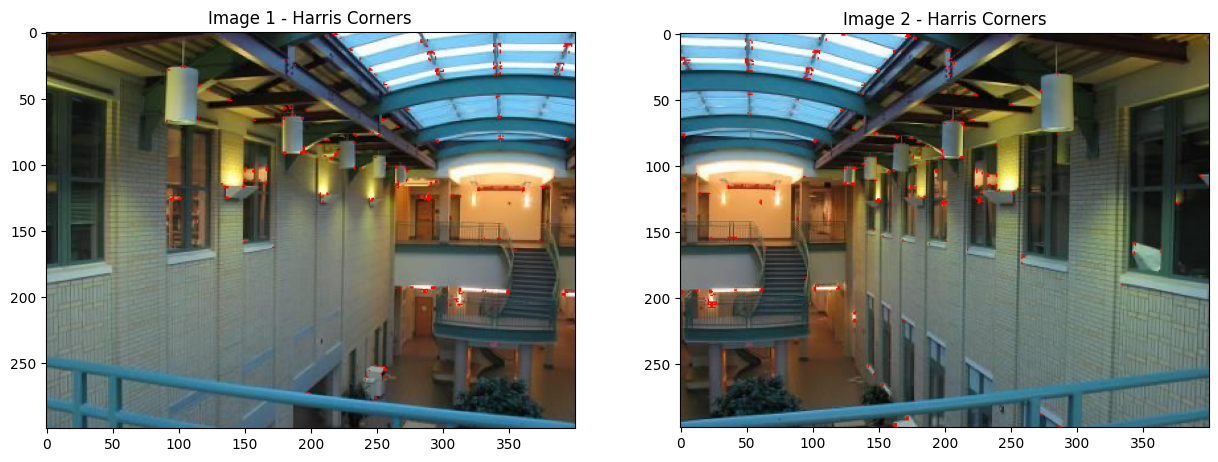

In [9]:
# Use Harris corner detection
corners1 = cv2.cornerHarris(_img1, 2, 3, 0.04)
corners2 = cv2.cornerHarris(_img2, 2, 3, 0.04)

# Visualize Harris corners
img1_harris = img1.copy()
img2_harris = img2.copy()
img1_harris[corners1 > 0.01 * corners1.max()] = [0, 0, 255]  # Red corners
img2_harris[corners2 > 0.01 * corners2.max()] = [0, 0, 255]  # Red corners

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_harris, cv2.COLOR_BGR2RGB))
plt.title('Image 1 - Harris Corners')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_harris, cv2.COLOR_BGR2RGB))
plt.title('Image 2 - Harris Corners')
plt.show()

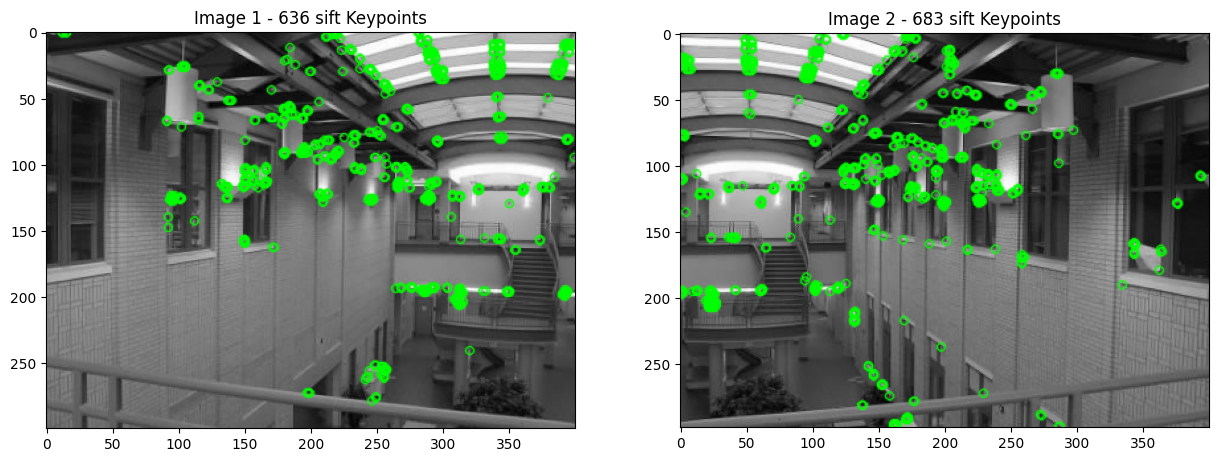

In [10]:
# Convert corners to keypoints
keypoints1 = [cv2.KeyPoint(float(x), float(y), 1) for y, x in zip(*np.where(corners1 > 0.01 * corners1.max()))]
keypoints2 = [cv2.KeyPoint(float(x), float(y), 1) for y, x in zip(*np.where(corners2 > 0.01 * corners2.max()))]

# Use sift for descriptor computation
sift = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptor1 = sift.compute(_img1, keypoints1)
keypoints2, descriptor2 = sift.compute(_img2, keypoints2)

# Visualize keypoints with descriptors
img1_kp = cv2.drawKeypoints(_img1, keypoints1, None, color=(0,255,0), flags=0)
img2_kp = cv2.drawKeypoints(_img2, keypoints2, None, color=(0,255,0), flags=0)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1_kp, cmap='gray')
plt.title(f'Image 1 - {len(keypoints1)} sift Keypoints')
plt.subplot(1, 2, 2)
plt.imshow(img2_kp, cmap='gray')
plt.title(f'Image 2 - {len(keypoints2)} sift Keypoints')
plt.show()

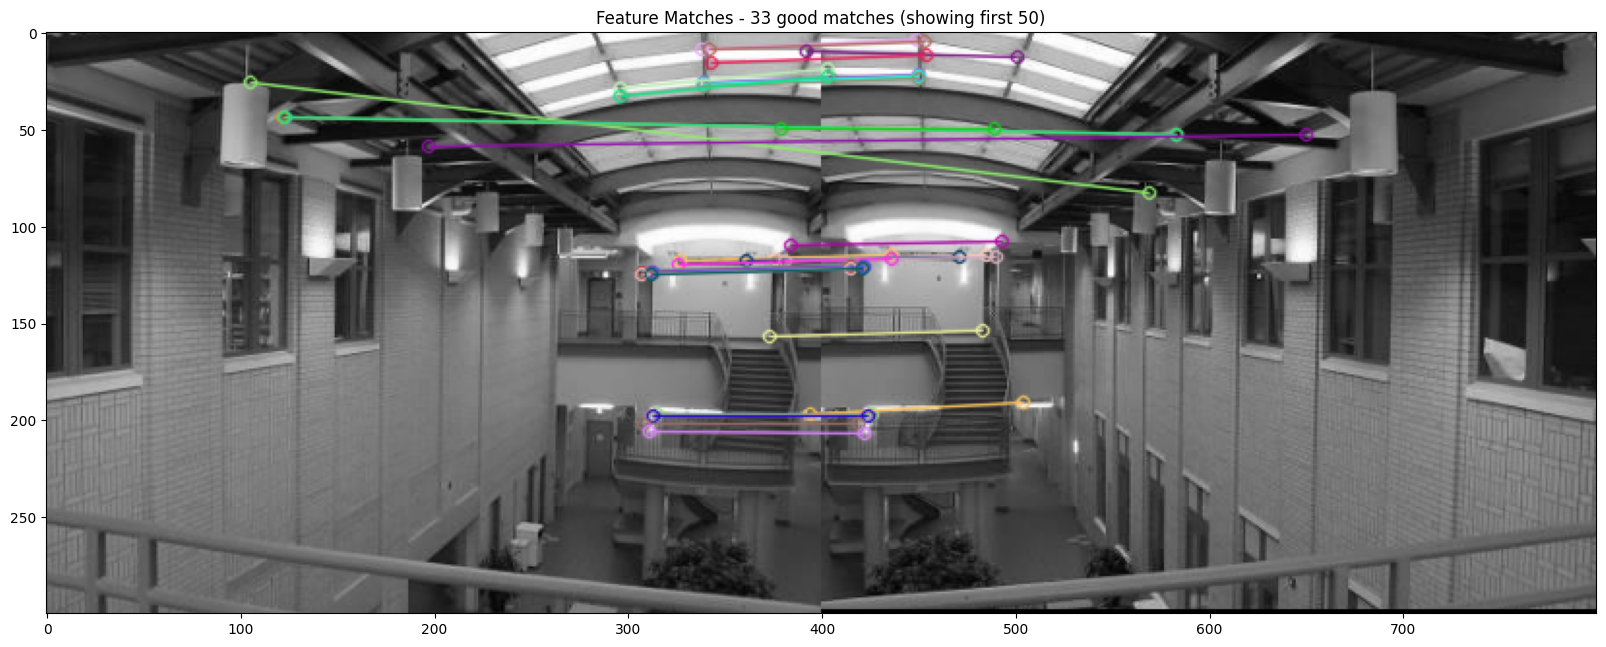

In [11]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptor1, descriptor2, k=2)

good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m[0])

# Visualize matches with lines
img_matches = cv2.drawMatches(_img1, keypoints1, _img2, keypoints2, good[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 8))
plt.imshow(img_matches, cmap='gray')
plt.title(f'Feature Matches - {len(good)} good matches (showing first 50)')
plt.show()


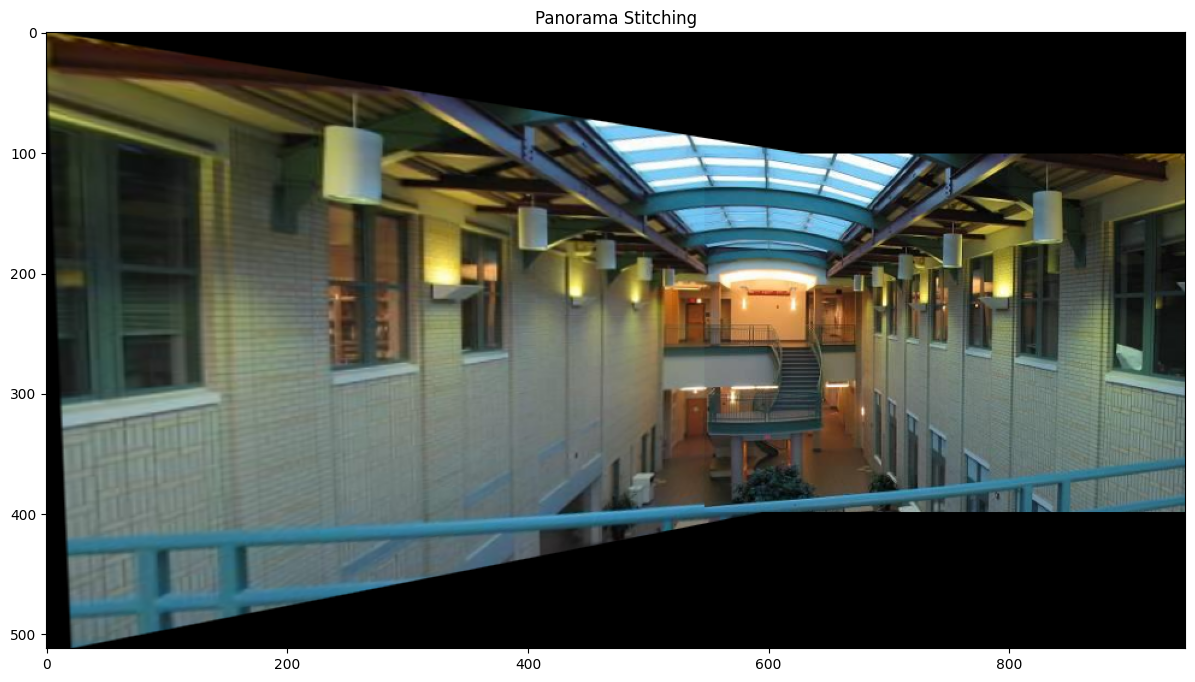

In [12]:
if len(good) >= 4:
  src = np.float32([ keypoints1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
  dst = np.float32([ keypoints2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
  H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
else:
  raise AssertionError("Can't find enough keypoints.")

# Get corners of both images
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
corners1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
corners2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)

# Transform corners of img1
corners1_transformed = cv2.perspectiveTransform(corners1, H)

# Find bounding box
all_corners = np.concatenate((corners1_transformed, corners2), axis=0)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

# Translation matrix
translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])

# Warp both images
result = cv2.warpPerspective(img1, translation.dot(H), (x_max-x_min, y_max-y_min))
result[-y_min:h2-y_min, -x_min:w2-x_min] = img2

cv2.imwrite('output.png', result)
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Panorama Stitching')
plt.show()

In [ ]:
#Alternatives to replace harris detection
sift = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptor1 = sift.detectAndCompute(_img1, None)
keypoints2, descriptor2 = sift.detectAndCompute(_img2, None)